# HSE 2023: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

$$ \text{ElasticNetLoss}(w) = \text{LogLoss} + \gamma L_1 + \beta L_2 $$

Из чего следует:

$$ \text{LogLoss} = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} $$
$$ L_1 = \| w \|_1 $$
$$ L_2 = \| w \|_2^2 $$

Находим производные:

$$ {\partial \text{LogLoss} \over \partial w} = 
\sum_{i=1}^N -y_i {1 \over \sigma{(w^\top x_i})} {\partial \over \partial w} \sigma{(w^\top x_i)} - (1 - y_i) {1 \over {1 - \sigma{(w^\top x_i})}} {\partial \over \partial w} (1 - \sigma{(w^\top x_i))} = $$

> Так как $${\partial \over \partial x} \sigma{(x)} = \sigma{(x)} (1 - \sigma{(x)})$$

$$ = \sum_{i=1}^N -y_i {1 \over \sigma{(w^\top x_i})} \sigma{(w^\top x_i)} {(1 - \sigma{(w^\top x_i)})} x_i + 
(1 - y_i) {1 \over {1 - \sigma{(w^\top x_i)}}} \sigma{(w^\top x_i)} (1 - \sigma{(w^\top x_i)}) x_i = $$
$$ = \sum_{i=1}^N -y_i {(1 - \sigma{(w^\top x_i)})} x_i + (1 - y_i) \sigma{(w^\top x_i)} x_i
= \sum_{i=1}^N x_i (\sigma{(w^\top x_i)} - y_i) $$

$$ {\partial L_1 \over \partial w} = \text{sign}(w) $$
$$ {\partial L_2 \over \partial w} = 2 w $$
> Так как
$$ {\partial L_1 \over \partial w_i} = {\partial \over \partial w_i} (|w_1| + |w_2| + \ldots + |w_n|) = \text{sign}(w_i) $$
$$ {\partial L_2 \over \partial w_i} = {\partial \over \partial w_i} (w_1^2 + w_2^2 + \ldots + w_n^2) = 2 w_i $$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

$$L(w) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
    sig = sigmoid(np.dot(X, w))
    
    log_loss = -y * np.log(sig) - (1 - y) * np.log(1 - sig)
    l1 = gamma * np.linalg.norm(w, 1)
    l2 = beta * np.linalg.norm(w, 2)**2
    loss = np.sum(log_loss) + l1 + l2
    
    return loss

#### 3. [0.25 points] Implement the gradient (as a function)

In [3]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    sig = sigmoid(np.dot(X, w))
    
    grad_w = np.dot(X.T, (sig - y)) + gamma * np.sign(w) + 2 * beta * w
    
    return grad_w

#### Check yourself

In [4]:
np.random.seed(42)

X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)

assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.w = None
        self.losses = []

    def fit(self, X, y):
        # Initialize weights randomly
        np.random.seed(self.random_state)
        self.w = np.random.rand(X.shape[1])

        # Perform gradient descent
        for i in range(self.max_iter):
            gradient = -np.dot(X.T, y - self.predict_proba(X)[1]) + self.beta * self.w + self.gamma * np.sign(self.w)
            # Update the weights
            new_w = self.w - self.learning_rate * gradient
            # Check for convergence
            if np.sqrt(np.sum((new_w - self.w) ** 2)) < self.tolerance:
                break
            self.w = new_w
            
            # Compute and store the loss
            self.losses.append(loss(X, y, self.w, self.gamma, self.beta))
        return self

    def predict(self, X):
        return (self.predict_proba(X)[1] > 0.5).astype(int)

    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(np.dot(X, self.w))),\
                         1 / (1 + np.exp(-np.dot(X, self.w)))])

    def plot_loss(self):
        plt.plot(self.losses)
        plt.title('Loss diagram')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'gamma': self.gamma,
            'lr': self.learning_rate,
            'max_iter': self.max_iter,
            'random_state': self.random_state,
            'tolerance': self.tolerance,
        }

In [7]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [8]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

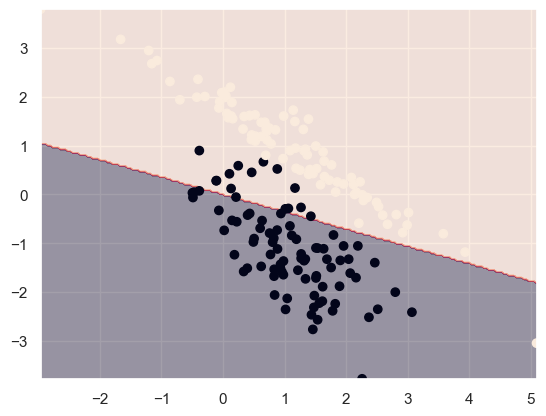

In [9]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

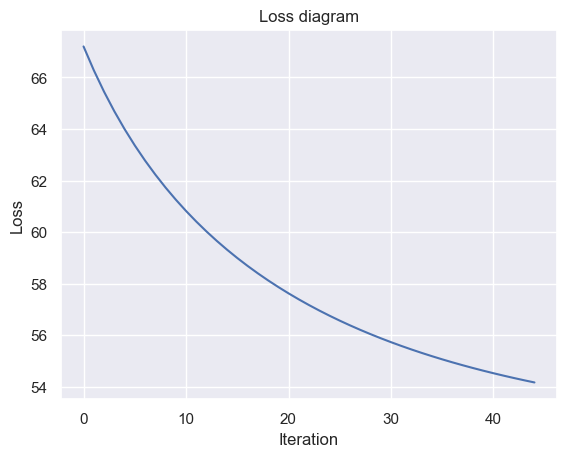

In [10]:
model = Logit()
model.fit(X, y)
model.plot_loss()

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

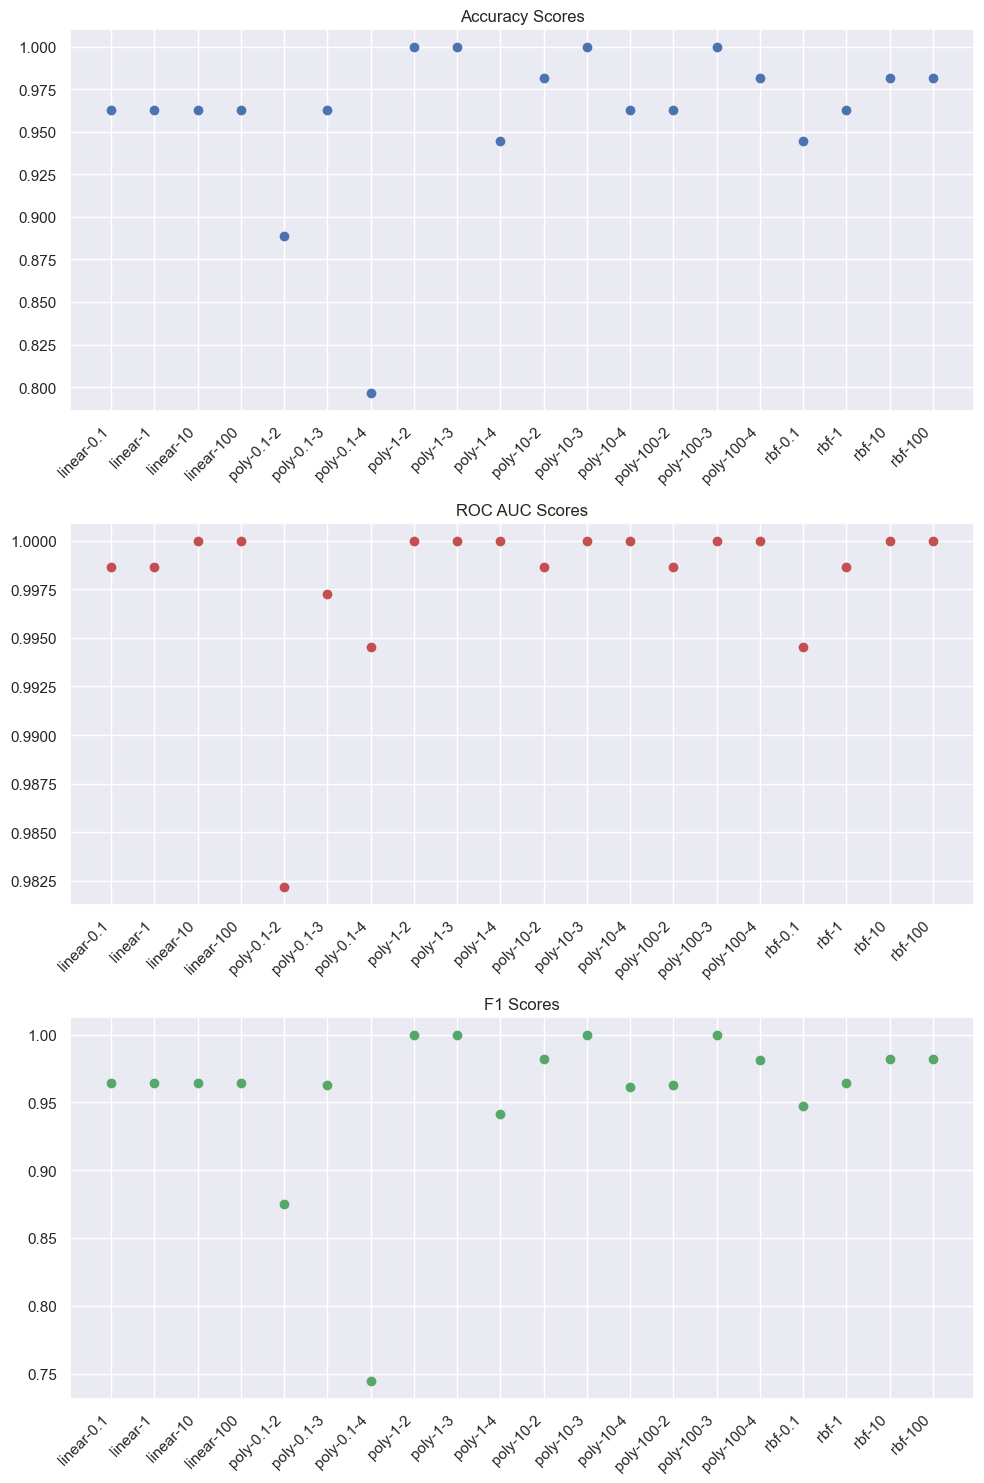

In [15]:
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV

# Define the SVM parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4],  # Degree for poly kernel
}

# Initialize lists to store results
kernels = []
C_values = []
degrees = []
accuracy_scores = []
roc_auc_scores = []
f1_scores = []

# Iterate over parameter combinations
for kernel in param_grid['kernel']:
    for C in param_grid['C']:
        if kernel == 'poly':
            for degree in param_grid['degree']:
                model = svm.SVC(kernel=kernel, C=C, degree=degree, probability=True)
                model.fit(X_train, y_train)

                # Predictions
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)[:, 1]

                # Metrics
                accuracy = accuracy_score(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_proba)
                f1 = f1_score(y_test, y_pred)

                # Append results to lists
                kernels.append(kernel)
                C_values.append(C)
                degrees.append(degree)
                accuracy_scores.append(accuracy)
                roc_auc_scores.append(roc_auc)
                f1_scores.append(f1)
        else:
            model = svm.SVC(kernel=kernel, C=C, probability=True)
            model.fit(X_train, y_train)

            # Predictions
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]

            # Metrics
            accuracy = accuracy_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_proba)
            f1 = f1_score(y_test, y_pred)

            # Append results to lists
            kernels.append(kernel)
            C_values.append(C)
            degrees.append(None)
            accuracy_scores.append(accuracy)
            roc_auc_scores.append(roc_auc)
            f1_scores.append(f1)

# Visualize the results
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Accuracy plot
axes[0].scatter(range(len(accuracy_scores)), accuracy_scores, c='b', marker='o')
axes[0].set_title('Accuracy Scores')
axes[0].set_xticks(range(len(accuracy_scores)))
axes[0].set_xticklabels([f'{kernel}-{C}-{degree}' if degree is not None else f'{kernel}-{C}' for kernel, C, degree in zip(kernels, C_values, degrees)], rotation=45, ha='right')

# ROC AUC plot
axes[1].scatter(range(len(roc_auc_scores)), roc_auc_scores, c='r', marker='o')
axes[1].set_title('ROC AUC Scores')
axes[1].set_xticks(range(len(roc_auc_scores)))
axes[1].set_xticklabels([f'{kernel}-{C}-{degree}' if degree is not None else f'{kernel}-{C}' for kernel, C, degree in zip(kernels, C_values, degrees)], rotation=45, ha='right')

# F1 Score plot
axes[2].scatter(range(len(f1_scores)), f1_scores, c='g', marker='o')
axes[2].set_title('F1 Scores')
axes[2].set_xticks(range(len(f1_scores)))
axes[2].set_xticklabels([f'{kernel}-{C}-{degree}' if degree is not None else f'{kernel}-{C}' for kernel, C, degree in zip(kernels, C_values, degrees)], rotation=45, ha='right')

plt.tight_layout()
plt.show()


В общем, хотя изменение гиперпараметров и регуляризации заметно изменяет полученные значения, в среднем точность достаточно высока и практически одинакова вне зависимости от их комбинаций.

Однако наблюдаются крайне низкие показатели poly (C = 0.1, degree = 2) и poly (C = 0.1, degree = 4) на всех графиках. Также, относительно низко располагается rbf (C = 0.1) на графике ROC AUC и poly (C = 1, degree = 4) на графиках Accuracy и F1.

Из произведённых наблюдений можно сделать выводы:

1. Линейное ядро хотя в среднем имеет не лучшие результаты, однако является наиболее стабильной при изменении гиперпараметров.
2. Полиномиальное ядро более чувствительно к своим гиперпараметрам и наиболее подвержено переобучению при высоких значениях степеней.
3. Результаты ядра RBF находятся примерно посередине между линейным  полиномиальном.
4. Регуляризация (параметр C) важна в предотвращении переобучения и позволяет получить наилучшие значения при нахождении баланса между недообучением и переобучением (например poly-10-3 и poly-1-3 имеют наилучшие показатели, тогда как показатели poly-1-3 ниже среднего; poly-0.1-4 и poly-1-4 достаточно низки, в то время как poly-10-4 выше среднего).

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [45]:
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string
from sklearn.utils import shuffle

# Assuming you have a list of directories where each directory is named after an author
directories = ['Chekhov', 'Dostoevsky', 'Gogol', 'Lermontov', 'Nekrasov', 'Tolstoy']

df = pd.DataFrame(columns=['sentence', 'author'])

# Read text files from each directory and create a dataframe
for directory in directories:
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r') as file:
            ext = os.path.splitext(filename)[1]
            if ext != '.txt':
                continue
            text = file.read()
            sentences = sent_tokenize(text)
            temp_df = pd.DataFrame(sentences, columns=['sentence'])
            temp_df['author'] = directory
            df = pd.concat([df, temp_df])

# Drop sentences with less than 15 symbols
df = df[df['sentence'].apply(lambda x: len(x) > 15)]

# Randomly choose sentences for each author
samples = [5000, 15000, 8000, 11000, 20000, 3000]
for directory, sample in zip(directories, samples):
    author_df = df[df['author'] == directory]
    if len(author_df) < sample:
        sample = len(author_df)
    author_df = author_df.sample(n=sample, random_state=1, replace=True)
    df = df[df['author'] != directory]
    df = pd.concat([df, author_df])

# Shuffle the dataframe
df = shuffle(df, random_state=1)

# Tokenize and clean the dataset
stop_words = set(stopwords.words('russian'))
df['sentence'] = df['sentence'].apply(lambda x: ' '.join([word for word in word_tokenize(x.lower()) if word.isalpha() and word not in stop_words and word not in string.punctuation]))

# Vectorize words using Bag of Words
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['sentence'])

# Vectorize words using TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['sentence'])

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [46]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Choose two authors
df = df[df['author'].isin(['Gogol', 'Lermontov'])]

# Check the balance of the classes
print(df['author'].value_counts())

# Divide the data into train and test samples
X = df['sentence']
y = df['author']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Transform the text data to TF-IDF features
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Standardize the features
scaler = StandardScaler()
X_train_tfidf = scaler.fit_transform(X_train_tfidf.toarray())
X_test_tfidf = scaler.transform(X_test_tfidf.toarray())

author
Dostoevsky    15000
Gogol          8000
Name: count, dtype: int64


In [47]:
# Define the models
logit = Logit()
svc = SVC()

# Define the parameter grids
# Define the parameter grid to search
logit_param_grid = {
    'beta': [0.1, 1.0, 10.0],
    'gamma': [0.1, 1.0, 10.0],
    'learning_rate': [1e-3, 1e-4],  # Updated parameter name
    'tolerance': [0.01, 0.001],
    'max_iter': [1000, 2000],
}

svc_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 10]
}

# Create a StratifiedKFold object for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a GridSearchCV object
logit_grid_search = GridSearchCV(logit, logit_param_grid, scoring='f1', cv=cv, verbose=1)
svc_grid_search = GridSearchCV(svc, svc_param_grid, scoring='f1', cv=5)

logit_grid_search.fit(X_train_tfidf, y_train)
svc_grid_search.fit(X_train_tfidf, y_train)

# Print the best parameters
print("Best parameters for Logit: ", logit_grid_search.best_params_)
print("Best parameters for SVC: ", svc_grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


ValueError: Invalid parameter 'learning_rate' for estimator Logit(beta=0.1, gamma=0.1). Valid parameters are: ['beta', 'gamma', 'lr', 'max_iter', 'random_state', 'tolerance'].

In [48]:
# Plot for Logit
plt.figure(figsize=(10, 5))
plt.plot(logit_grid_search.cv_results_['mean_test_score'])
plt.title('Logit: F1 Score vs Parameters')
plt.xlabel('Parameters')
plt.ylabel('F1 Score')
plt.show()

# Plot for SVC
plt.figure(figsize=(10, 5))
plt.plot(svc_grid_search.cv_results_['mean_test_score'])
plt.title('SVC: F1 Score vs Parameters')
plt.xlabel('Parameters')
plt.ylabel('F1 Score')
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

<Figure size 1000x500 with 0 Axes>

In [49]:
# Predictions
y_train_pred_logit = logit_grid_search.predict(X_train_tfidf)
y_test_pred_logit = logit_grid_search.predict(X_test_tfidf)
y_train_pred_svc = svc_grid_search.predict(X_train_tfidf)
y_test_pred_svc = svc_grid_search.predict(X_test_tfidf)

# Confusion matrices
cm_train_logit = confusion_matrix(y_train, y_train_pred_logit)
cm_test_logit = confusion_matrix(y_test, y_test_pred_logit)
cm_train_svc = confusion_matrix(y_train, y_train_pred_svc)
cm_test_svc = confusion_matrix(y_test, y_test_pred_svc)

# Plot
sns.heatmap(cm_train_logit, annot=True, fmt='d')
plt.title('Logit: Confusion matrix for train samples')
plt.show()

sns.heatmap(cm_test_logit, annot=True, fmt='d')
plt.title('Logit: Confusion matrix for test samples')
plt.show()

sns.heatmap(cm_train_svc, annot=True, fmt='d')
plt.title('SVC: Confusion matrix for train samples')
plt.show()

sns.heatmap(cm_test_svc, annot=True, fmt='d')
plt.title('SVC: Confusion matrix for test samples')
plt.show()

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [50]:
# Logit
print("Logit classification report for test samples:\n", classification_report(y_test, y_test_pred_logit))

# SVC
print("SVC classification report for test samples:\n", classification_report(y_test, y_test_pred_svc))

NameError: name 'y_test_pred_logit' is not defined

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

In [ ]:
# your code here

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [ ]:
# your code here